In [1]:
import argparse
import logging
import pickle
from pathlib import Path

import pandas as pd

from digital_twin.models.norm_flow.model import NormFlowModel, DEFAULT_CHECKPOINTS_DIR
from digital_twin.models.density_estimation import GMM, Grouper, Regressor
from sklearn.model_selection import train_test_split
import torch
import random
import numpy as np
from glob import glob
import pandas as pd
import os, sys

from sklearn.metrics import make_scorer
from tqdm.contrib.concurrent import process_map
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from digital_twin.performance_metrics import ape

In [8]:
dirpath = "../dataset/"

data_files = ["cache/test_cache.csv", 
              "pools/test_ssd_random.csv", 
              "pools/test_ssd_sequential.csv", 
              "pools/test_hdd_sequential.csv"]

## NF model

In [9]:
def get_X_y(df):
    df[['r0', 'r1']] = df['raid'].str.split('+', n=1, expand=True)
    df.replace({'random': 0, 'sequential': 1, 'read': 0, 'write': 1}, inplace=True)
    return df.drop(["iops", "lat", "id", 'raid', 'device_type', 'offset'], axis=1), df[["iops", "lat"]]

In [10]:
def get_params(df):
    np.random.seed(1223)
    xx = df.sample()
    xx.reset_index(drop=True, inplace=True)
    sampled_params = xx.iloc[0].to_dict()
    return sampled_params

In [25]:
def plot_graphs(df_, cols_to_check):
    for col in cols_to_check:
        display(f'Now plotting the {col} values')
        start = df_[col].min()
        stop = df_[col].max()
        new_vals = np.arange(start, stop)
        sampled_params = get_params(df)
        metrics = []
        for val in new_vals:
            sampled_params[col] = val
            metric = model.sample(sampled_params, n_samples=100).mean(0)

            metrics.append(metric)        
        metrics = np.array(metrics).T
        # fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

        # Plot the first histogram
        sns.histplot(x=new_vals, weights=metrics[0], bins=len(new_vals), kde=False, color='blue')
        title = f'IOPS Over {col} distribution'
        plt.title(title)
        plt.xlabel(f'{col} values')
        plt.ylabel('IOPS Distribution')
        plt.grid(False)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'../new_plots/{model_name}/{data_name}-{title}.png')
        plt.close()
        # Plot the second histogram
        sns.histplot(x=new_vals, weights=metrics[1], bins=len(new_vals), kde=False, color='green')
        title = f'Latency over {col} Distribution'
        plt.title(title)
        plt.xlabel(f'{col} values')
        plt.ylabel('Latency Distribution')
        plt.grid(False)
    
        # Show the plots
        plt.tight_layout()
        plt.show()
        plt.savefig(f'../new_plots/{model_name}/{data_name}-{title}.png')
        plt.close()

In [26]:
def get_model(model_cls, data):
    t = data.split('/')
    t[1] = t[1].split('_')
    t[1][0] = 'nf_train'
    t[1][-1] = t[1][-1].split('.')[0]
    m_p = '_'.join(t[1])
    path = f'{t[0]}/{m_p}'
    ckpt_dir = f'../models_checkpoints/{path}/'
    print(f'Reading the {ckpt_dir} checkpoint')
    model = model_cls.load(ckpt_dir)
    return model

Reading the cache/test_cache.csv data
Reading the ../models_checkpoints/cache/nf_train_cache/ checkpoint


/home/atemirkhanov/digital-twin/digital_twin/models/norm_flow/model.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(latest_file, map_location=D

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id
0,712511,386627.74,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
1,709311,388112.33,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
2,712464,386384.72,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769


Working with ['block_size', 'n_jobs', 'iodepth', 'read_fraction'] params


/tmp/job-2219702/ipykernel_64588/2451327043.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'random': 0, 'sequential': 1, 'read': 0, 'write': 1}, inplace=True)


'Now plotting the block_size values'

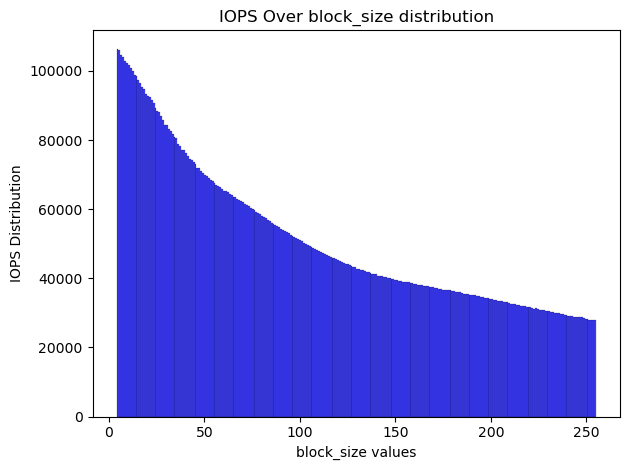

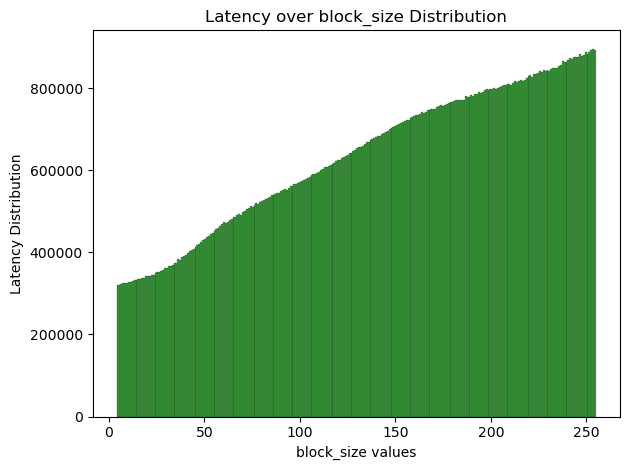

'Now plotting the n_jobs values'

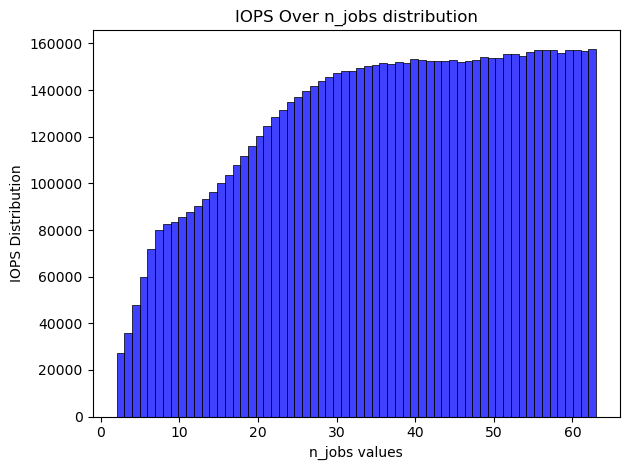

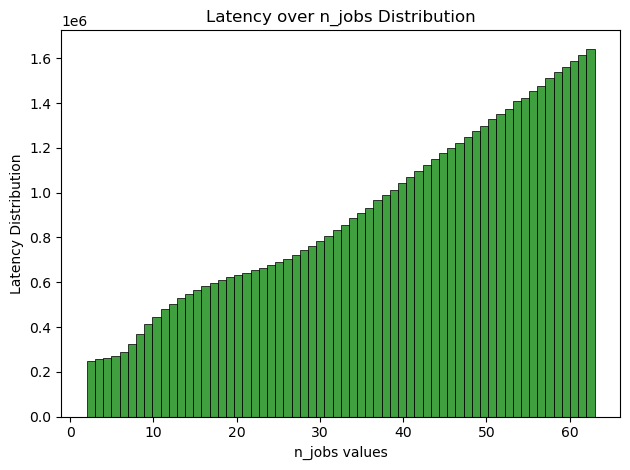

'Now plotting the iodepth values'

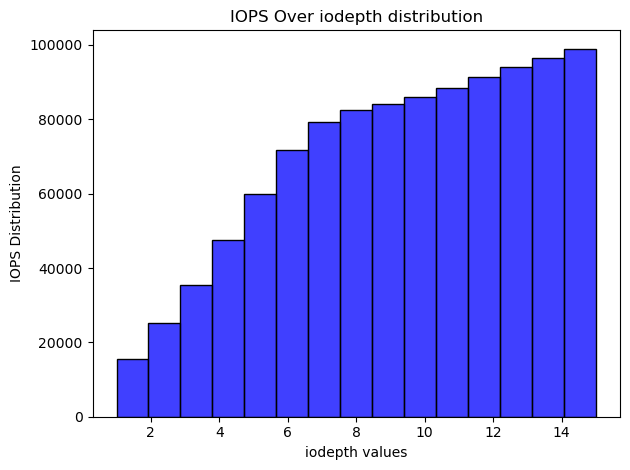

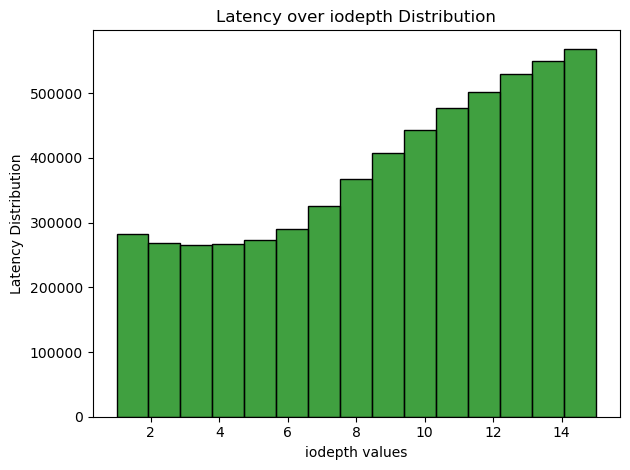

'Now plotting the read_fraction values'

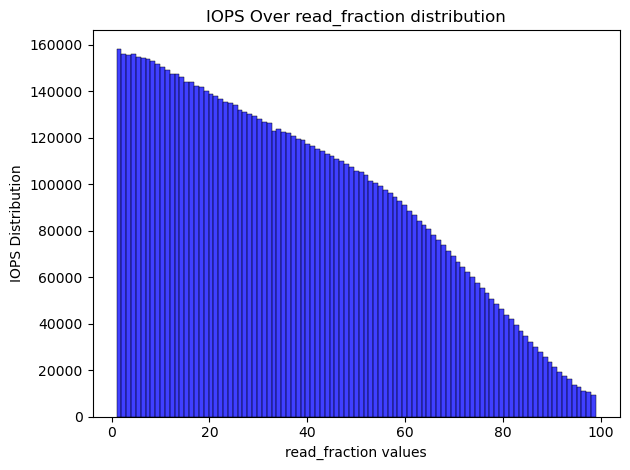

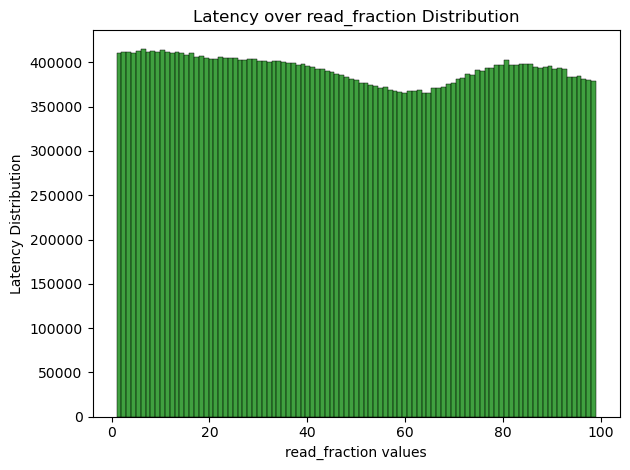

Reading the pools/test_ssd_random.csv data
Reading the ../models_checkpoints/pools/nf_train_ssd_random/ checkpoint


/home/atemirkhanov/digital-twin/digital_twin/models/norm_flow/model.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(latest_file, map_location=D

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id
0,313736,856394.83,8,12,30,79,random,read,8+2,21,nvme,0,hse-07102022-232335-z21223
1,306702,870677.58,8,12,30,79,random,read,8+2,21,nvme,0,hse-07102022-232335-z21223
2,306157,871821.25,8,12,30,79,random,read,8+2,21,nvme,0,hse-07102022-232335-z21223


Working with ['n_jobs', 'iodepth', 'read_fraction', 'n_disks'] params


/tmp/job-2219702/ipykernel_64588/2451327043.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'random': 0, 'sequential': 1, 'read': 0, 'write': 1}, inplace=True)


'Now plotting the n_jobs values'

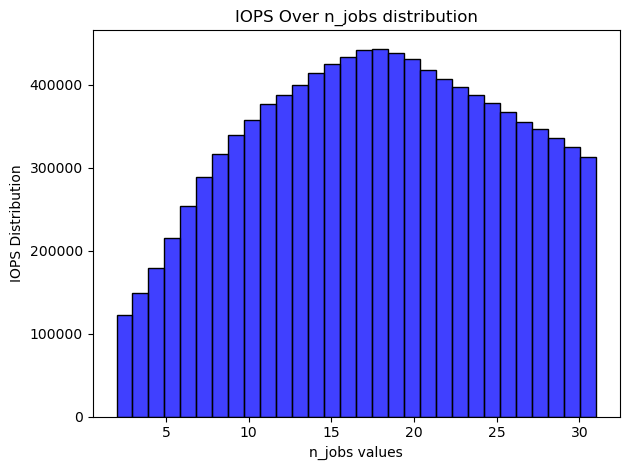

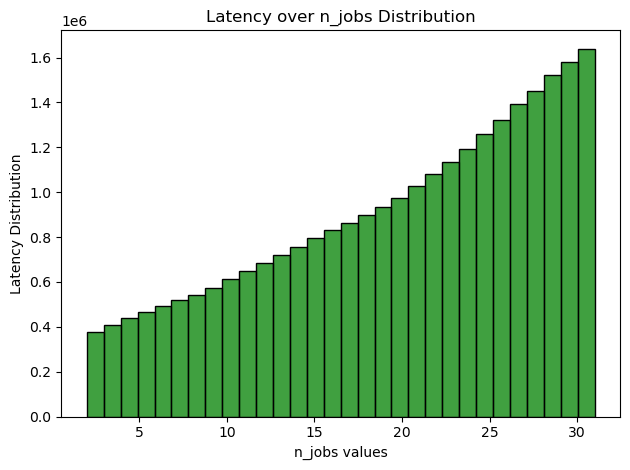

'Now plotting the iodepth values'

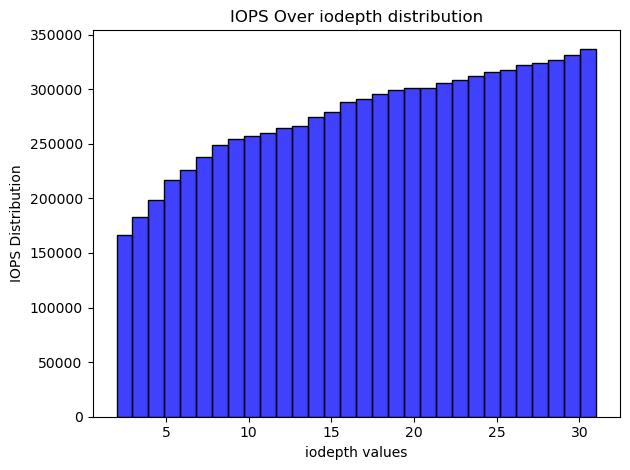

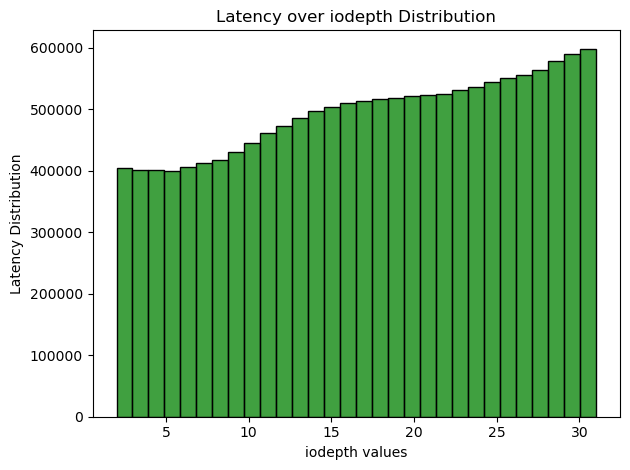

'Now plotting the read_fraction values'

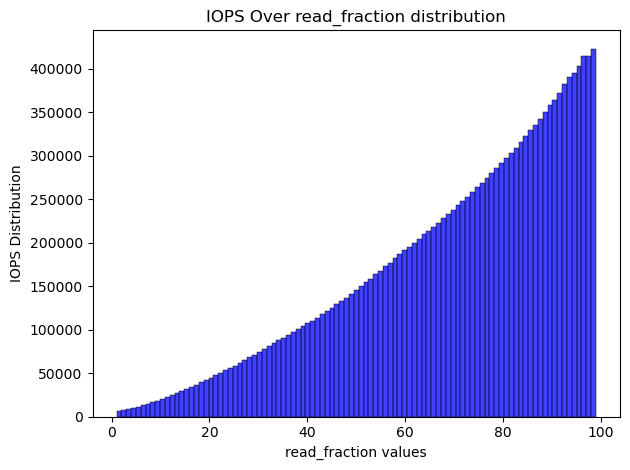

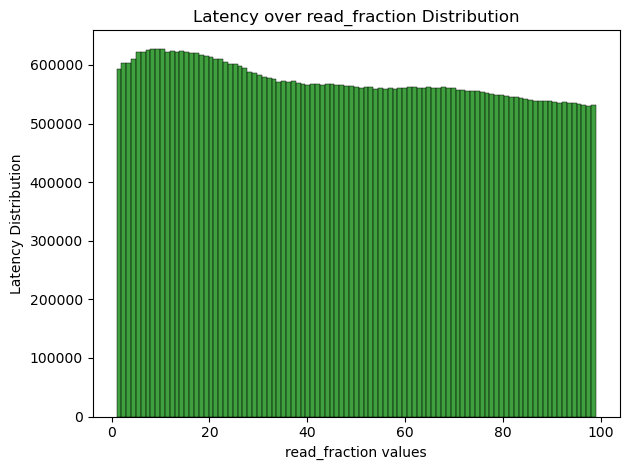

'Now plotting the n_disks values'

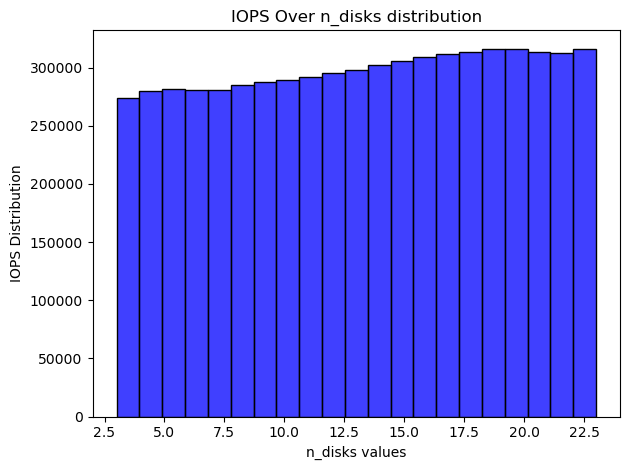

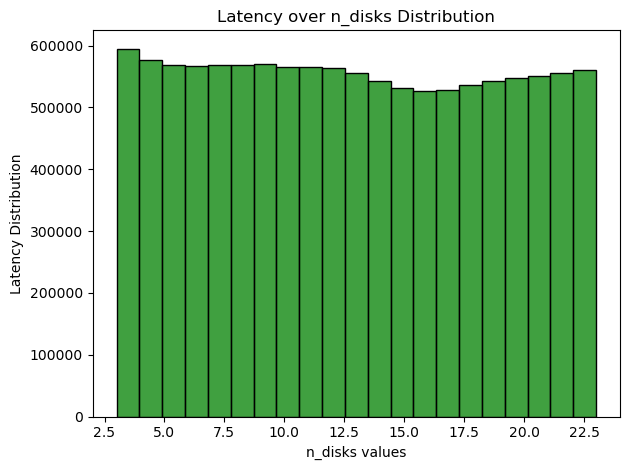

Reading the pools/test_ssd_sequential.csv data
Reading the ../models_checkpoints/pools/nf_train_ssd_sequential/ checkpoint


/home/atemirkhanov/digital-twin/digital_twin/models/norm_flow/model.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(latest_file, map_location=D

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id
0,17731,7048607.86,512,7,18,0,sequential,write,4+1,10,nvme,0,hse-08242022-195634-z42527
1,15689,8003059.00,512,7,18,0,sequential,write,4+1,10,nvme,0,hse-08242022-195634-z42527
2,14829,8486891.14,512,7,18,0,sequential,write,4+1,10,nvme,0,hse-08242022-195634-z42527


Working with ['n_jobs', 'iodepth', 'n_disks'] params


/tmp/job-2219702/ipykernel_64588/2451327043.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'random': 0, 'sequential': 1, 'read': 0, 'write': 1}, inplace=True)


'Now plotting the n_jobs values'

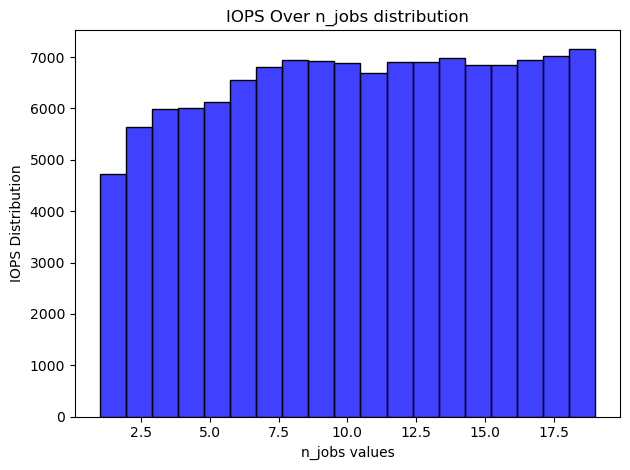

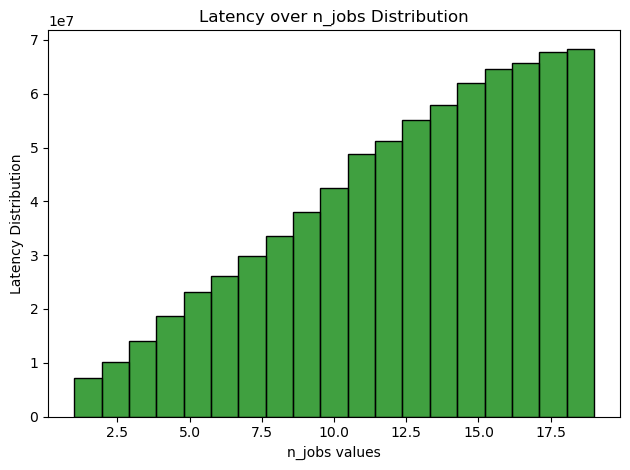

'Now plotting the iodepth values'

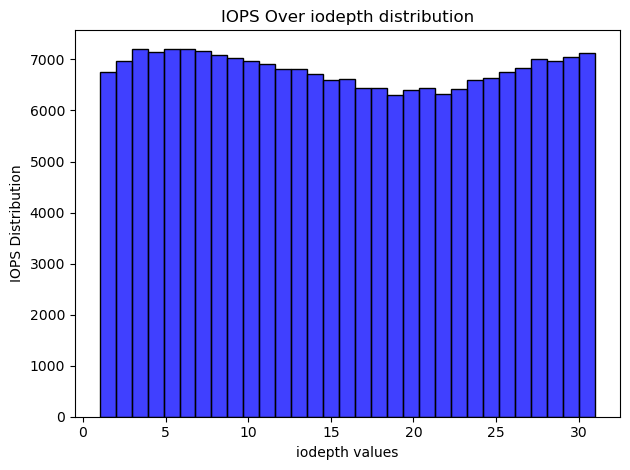

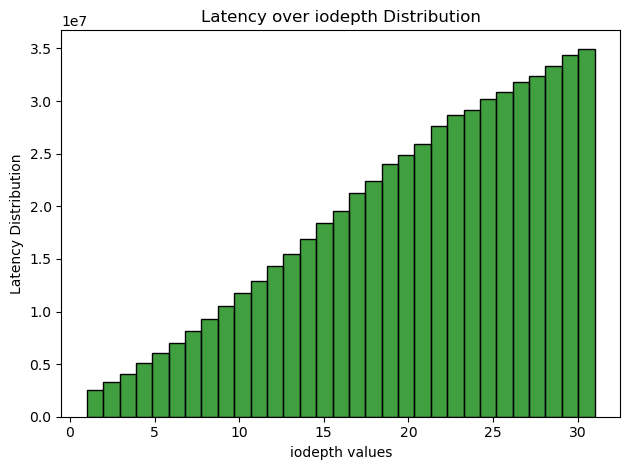

'Now plotting the n_disks values'

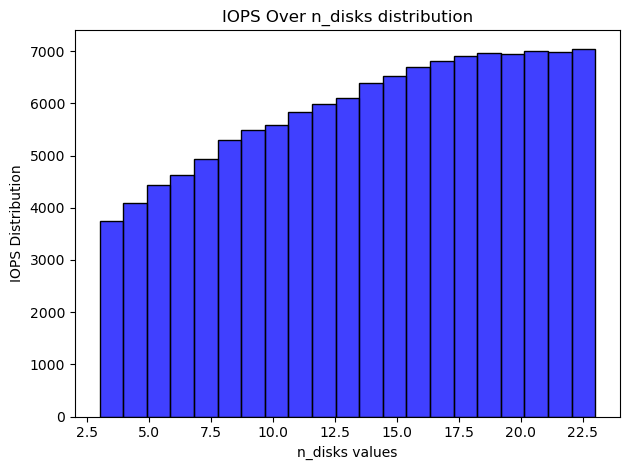

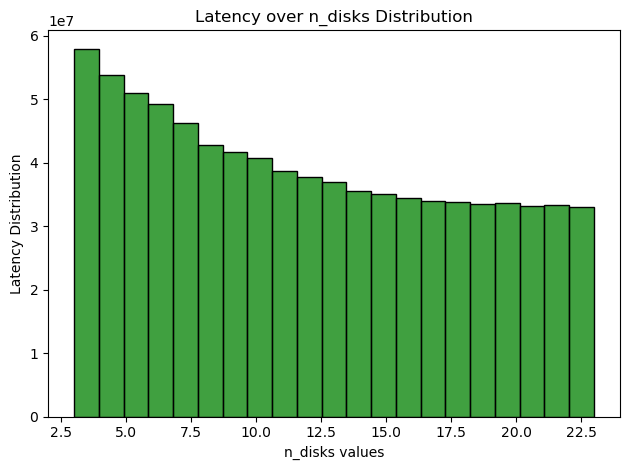

Reading the pools/test_hdd_sequential.csv data
Reading the ../models_checkpoints/pools/nf_train_hdd_sequential/ checkpoint


/home/atemirkhanov/digital-twin/digital_twin/models/norm_flow/model.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(latest_file, map_location=D

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id
0,13558,14577138.4,128,10,20,100,sequential,read,8+2,24,hdd,0,hse-08312022-013051-z66508
1,13548,14918342.1,128,10,20,100,sequential,read,8+2,24,hdd,0,hse-08312022-013051-z66508
2,12911,15447161.0,128,10,20,100,sequential,read,8+2,24,hdd,0,hse-08312022-013051-z66508


Working with ['n_jobs', 'iodepth', 'n_disks'] params


/tmp/job-2219702/ipykernel_64588/2451327043.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'random': 0, 'sequential': 1, 'read': 0, 'write': 1}, inplace=True)


'Now plotting the n_jobs values'

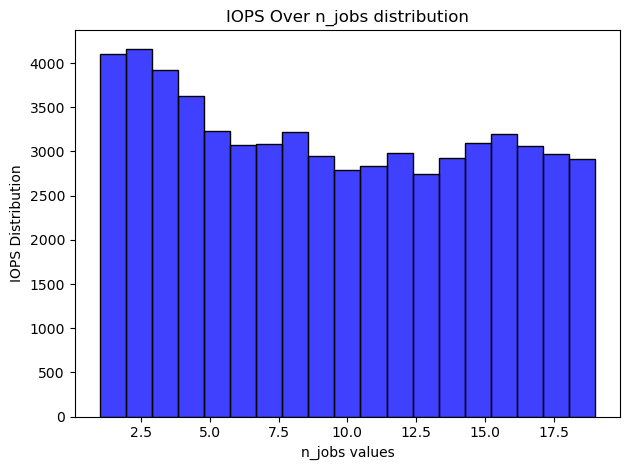

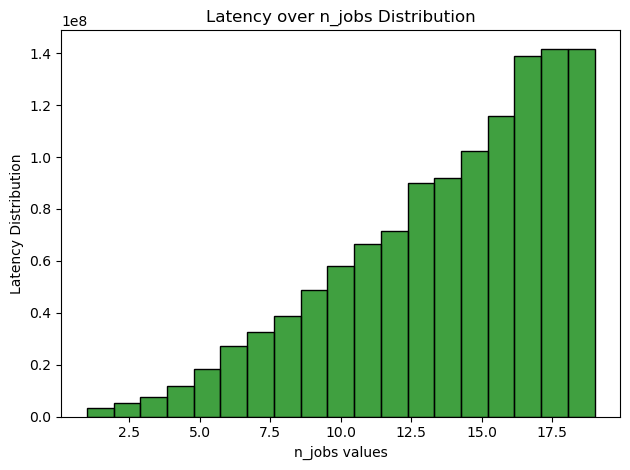

'Now plotting the iodepth values'

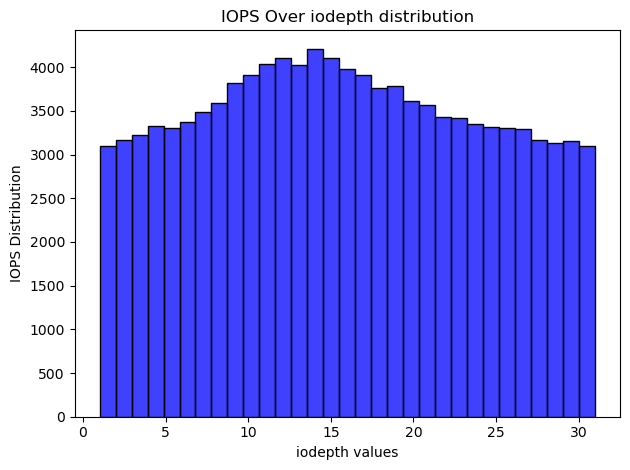

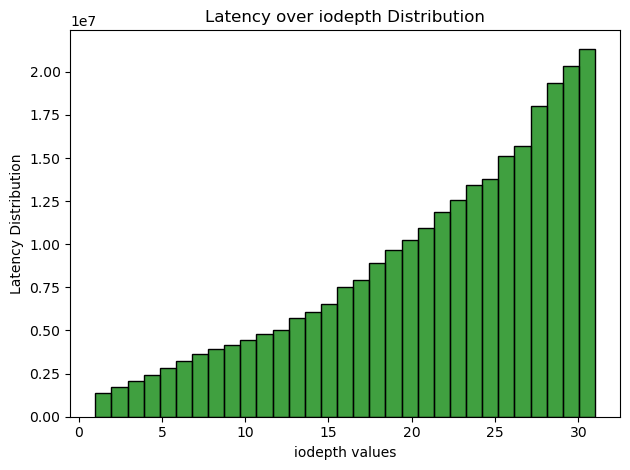

'Now plotting the n_disks values'

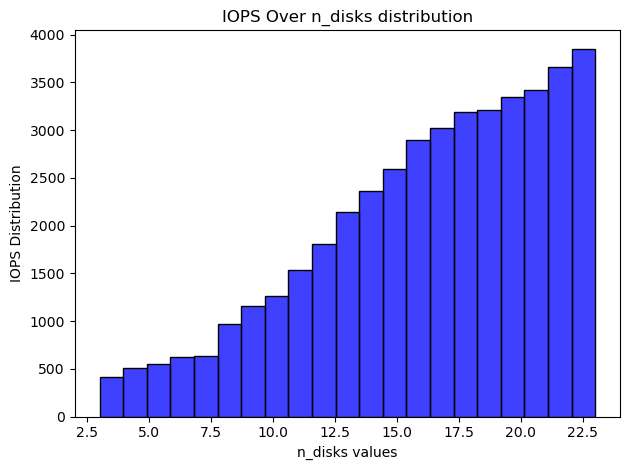

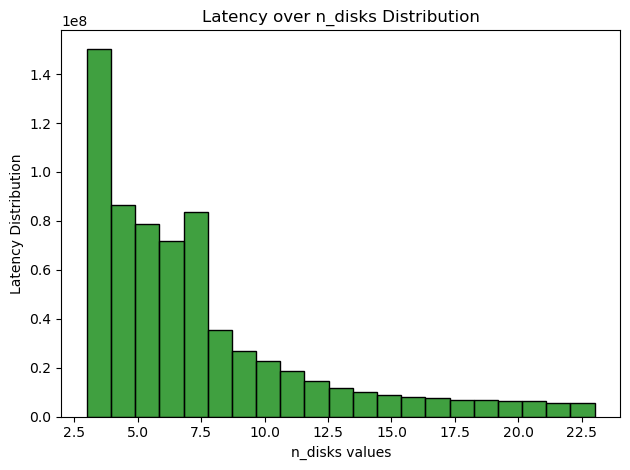

In [27]:
model_name = 'nf'

for adata in data_files:
    print(f'Reading the {adata} data')
    data_name = '_'.join(adata.split('/')[-1].split('.')[0].split('_')[1:])
    df = pd.read_csv(dirpath+adata)
    model = get_model(NormFlowModel, adata)
    try: 
        df.rename(columns={'Unnamed: 0':'iops'}, inplace=True)
    except KeyError:
        pass
    finally:
        display(df.head(3))
        
    X, _ = get_X_y(df)
    unique_values = X.apply(lambda x: x.unique())
    cols = [col for col in unique_values.index if len(unique_values[col]) > 5]
    
    print(f'Working with {cols} params')
    
    plot_graphs(X, cols)